In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

### THORACIC SURGERY

In [8]:
# fetch dataset 
thoracic_surgery_data = pd.read_csv("data/thoracic_surgery/thoracic_surgery.csv")

thoracic_surgery_data.head()

,id,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,1,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
1,2,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
2,3,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
3,4,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
4,5,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T


In [9]:
def preprocess_thoracic(data):

    # drop the ID column
    data = data.drop(columns=["id"], axis=1)
    
    numerical_cols = [col for col in data.columns if data[col].dtype != 'object']
    non_numerical_cols = [col for col in data.columns if data[col].dtype == 'object']
    
    # print the indeces of the numerical and non-numerical columns
    print("Numerical columns indeces: " , [data.columns.get_loc(col) for col in numerical_cols])  
    print("Non-numerical columns indeces: " , [data.columns.get_loc(col) for col in non_numerical_cols])
    
    print("Numerical columns: ", numerical_cols)
    print("Non-numerical columns: ", non_numerical_cols)
        
    pre_six = {"PRZ0": 0, "PRZ1": 1, "PRZ2": 2}
    pre_14 = {"OC11": 0, "OC12": 1, "OC13": 2, "OC14": 3}

    data = pd.get_dummies(data, columns=["DGN"], drop_first=True)

    data.loc[:, "PRE6"] = data["PRE6"].map(pre_six)
    data.loc[:, "PRE14"] = data["PRE14"].map(pre_14)

    bool_columns = data.columns[data.isin(['T', 'F']).any()]
    data.loc[:, bool_columns] = data[bool_columns].replace({'T': 1, 'F': 0}).infer_objects(copy=False)

    data.loc[:, "Risk1Yr"] = data["Risk1Yr"].replace({'T': 1, 'F': 0}).infer_objects(copy=False)
    
    ind_out = data["PRE5"] > 15
    data.drop(data[ind_out].index, inplace=True)
    
    # boolean columns to 0, 1
    data = data.astype(float)
    
    return data, numerical_cols, non_numerical_cols

In [10]:
thoracic_surgery_data, numerical_cols, non_numerical_cols = preprocess_thoracic(thoracic_surgery_data)

Numerical columns indeces:  [1, 2, 15]
Non-numerical columns indeces:  [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]
Numerical columns:  ['PRE4', 'PRE5', 'AGE']
Non-numerical columns:  ['DGN', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'Risk1Yr']


/tmp/ipykernel_2572631/3080736288.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:, bool_columns] = data[bool_columns].replace({'T': 1, 'F': 0}).infer_objects(copy=False)
/tmp/ipykernel_2572631/3080736288.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:, "Risk1Yr"] = data["Risk1Yr"].replace({'T': 1, 'F': 0}).infer_objects(copy=False)


In [11]:
# save thoracic_surgery_data

thoracic_surgery_data.to_csv("data/thoracic_surgery/thoracic_surgery.csv", index=False)

In [36]:
import json

metadata = {
    "name": "thoracic_surgery",
    "task_type": "binclass",  # binclass or regression or multiclass
    "header": "infer",
    "column_names": None,
    "num_col_idx": [1,2,15],  # list of indices of numerical columns
    "cat_col_idx": [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,16],  # list of indices of categorical columns
    "target_col_idx": [16],  # list of indices of the target columns (for MLE)
    "file_type": "csv",
    "data_path": f"data/thoracic_surgery/thoracic_surgery.csv",
    "test_path": None,
}
with open("data/Info/thoracic_surgery.json", "w") as json_file:
    json.dump(metadata, json_file, indent=4)

In [5]:
thoracic_X = thoracic_surgery_data.drop(columns=["Risk1Yr"])
thoracic_y = thoracic_surgery_data["Risk1Yr"]

In [8]:
thoracic_surgery_data.head(20)

,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr,DGN_DGN2,DGN_DGN3,DGN_DGN4,DGN_DGN5,DGN_DGN6,DGN_DGN8
0,2.88,2.16,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,60.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3.40,1.88,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.76,2.08,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.68,3.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2.44,0.96,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,73.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,2.48,1.88,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,4.36,3.28,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,59.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
7,3.19,2.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,66.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,3.16,2.64,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,2.32,2.16,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,54.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


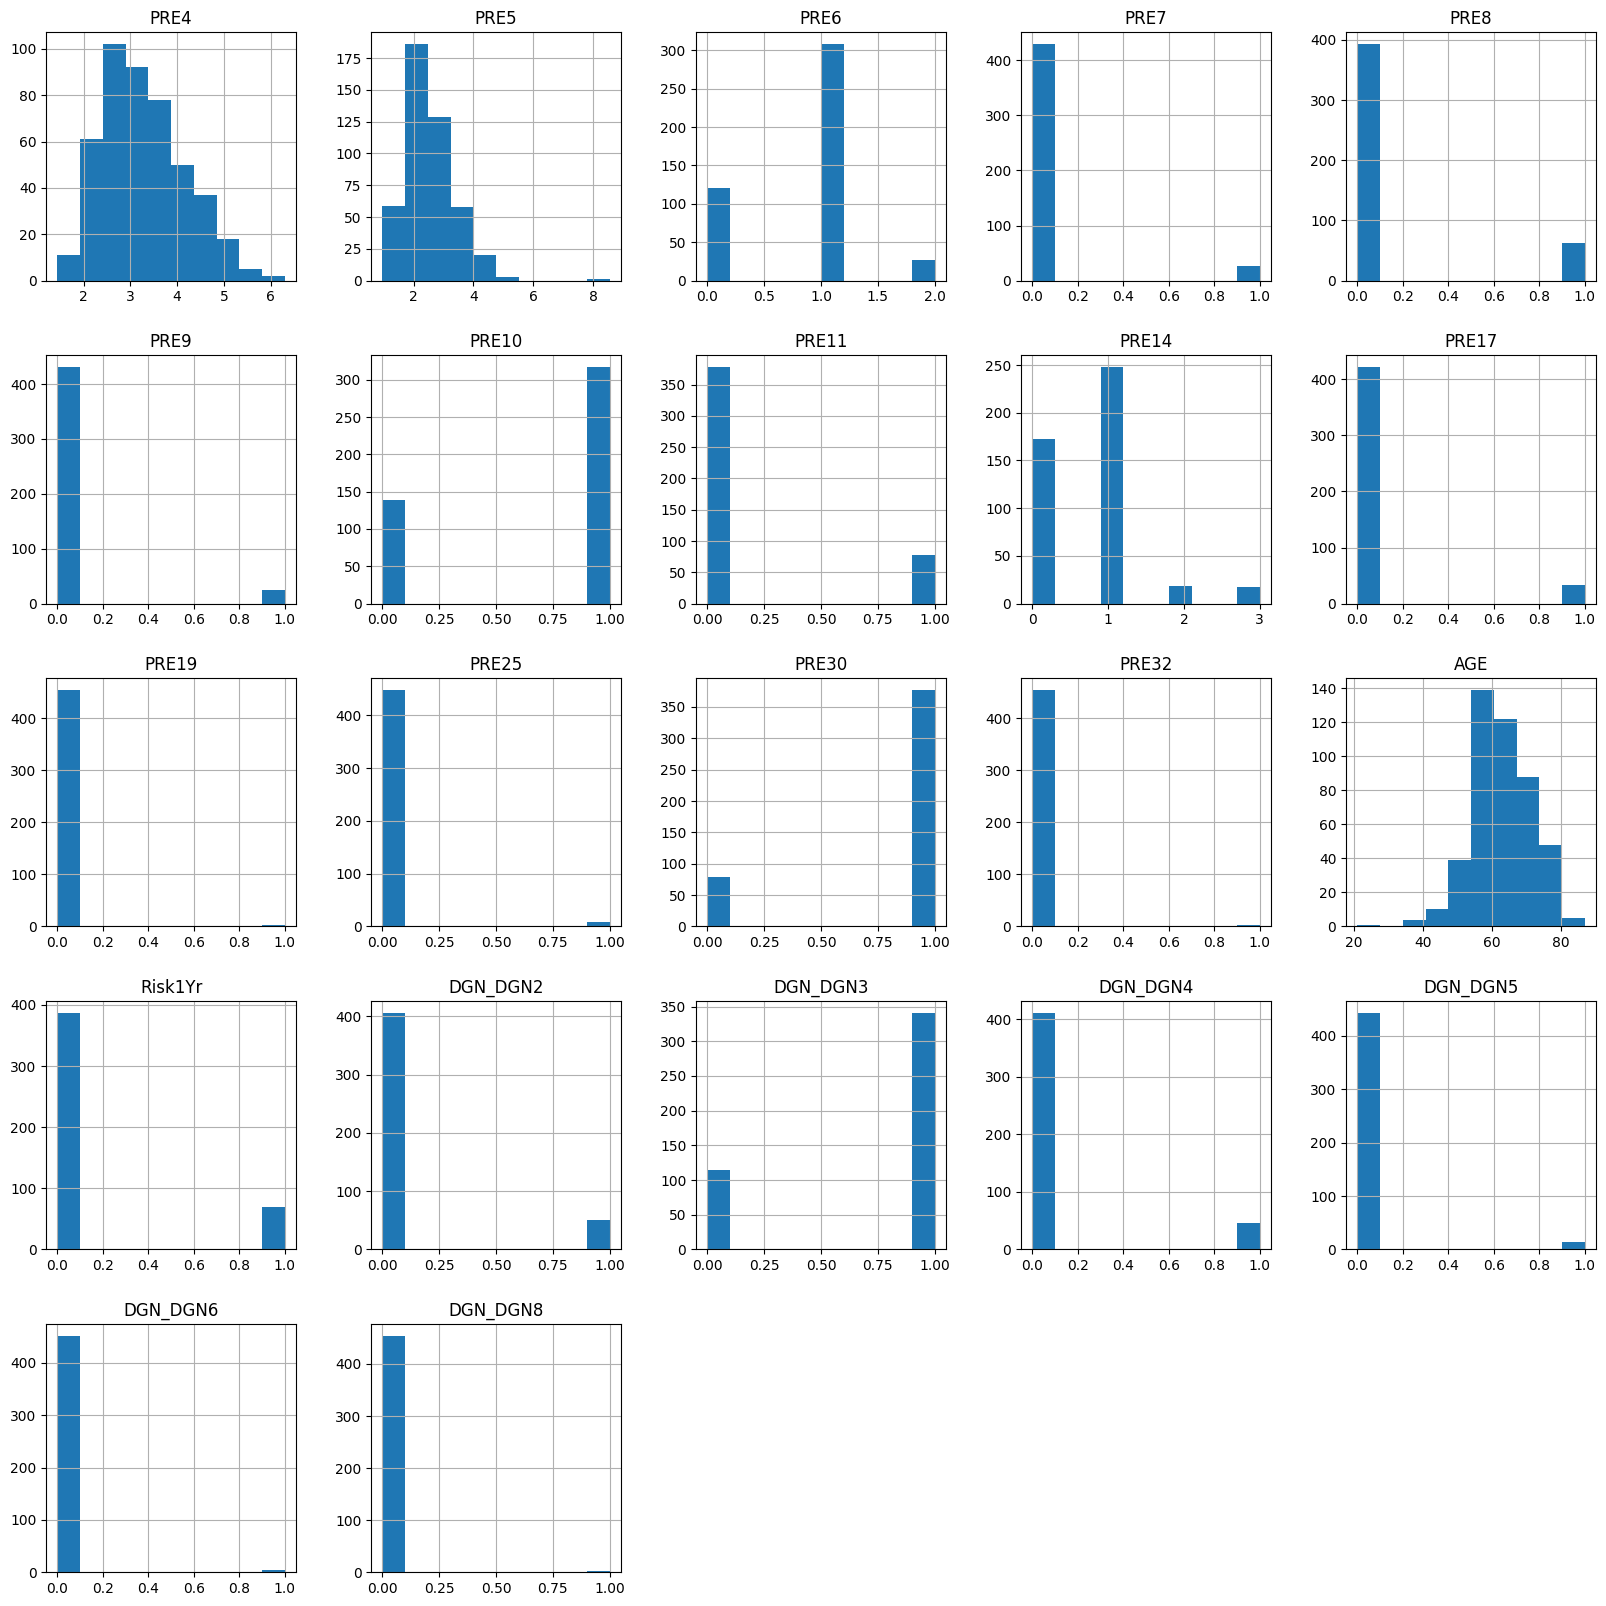

In [7]:
p = thoracic_surgery_data.hist(figsize = (20,20))

In [90]:
thoracic_X.isna().sum()

PRE4        0
PRE5        0
PRE6        0
PRE7        0
PRE8        0
PRE9        0
PRE10       0
PRE11       0
PRE14       0
PRE17       0
PRE19       0
PRE25       0
PRE30       0
PRE32       0
AGE         0
DGN_DGN2    0
DGN_DGN3    0
DGN_DGN4    0
DGN_DGN5    0
DGN_DGN6    0
DGN_DGN8    0
dtype: int64

<Axes: >

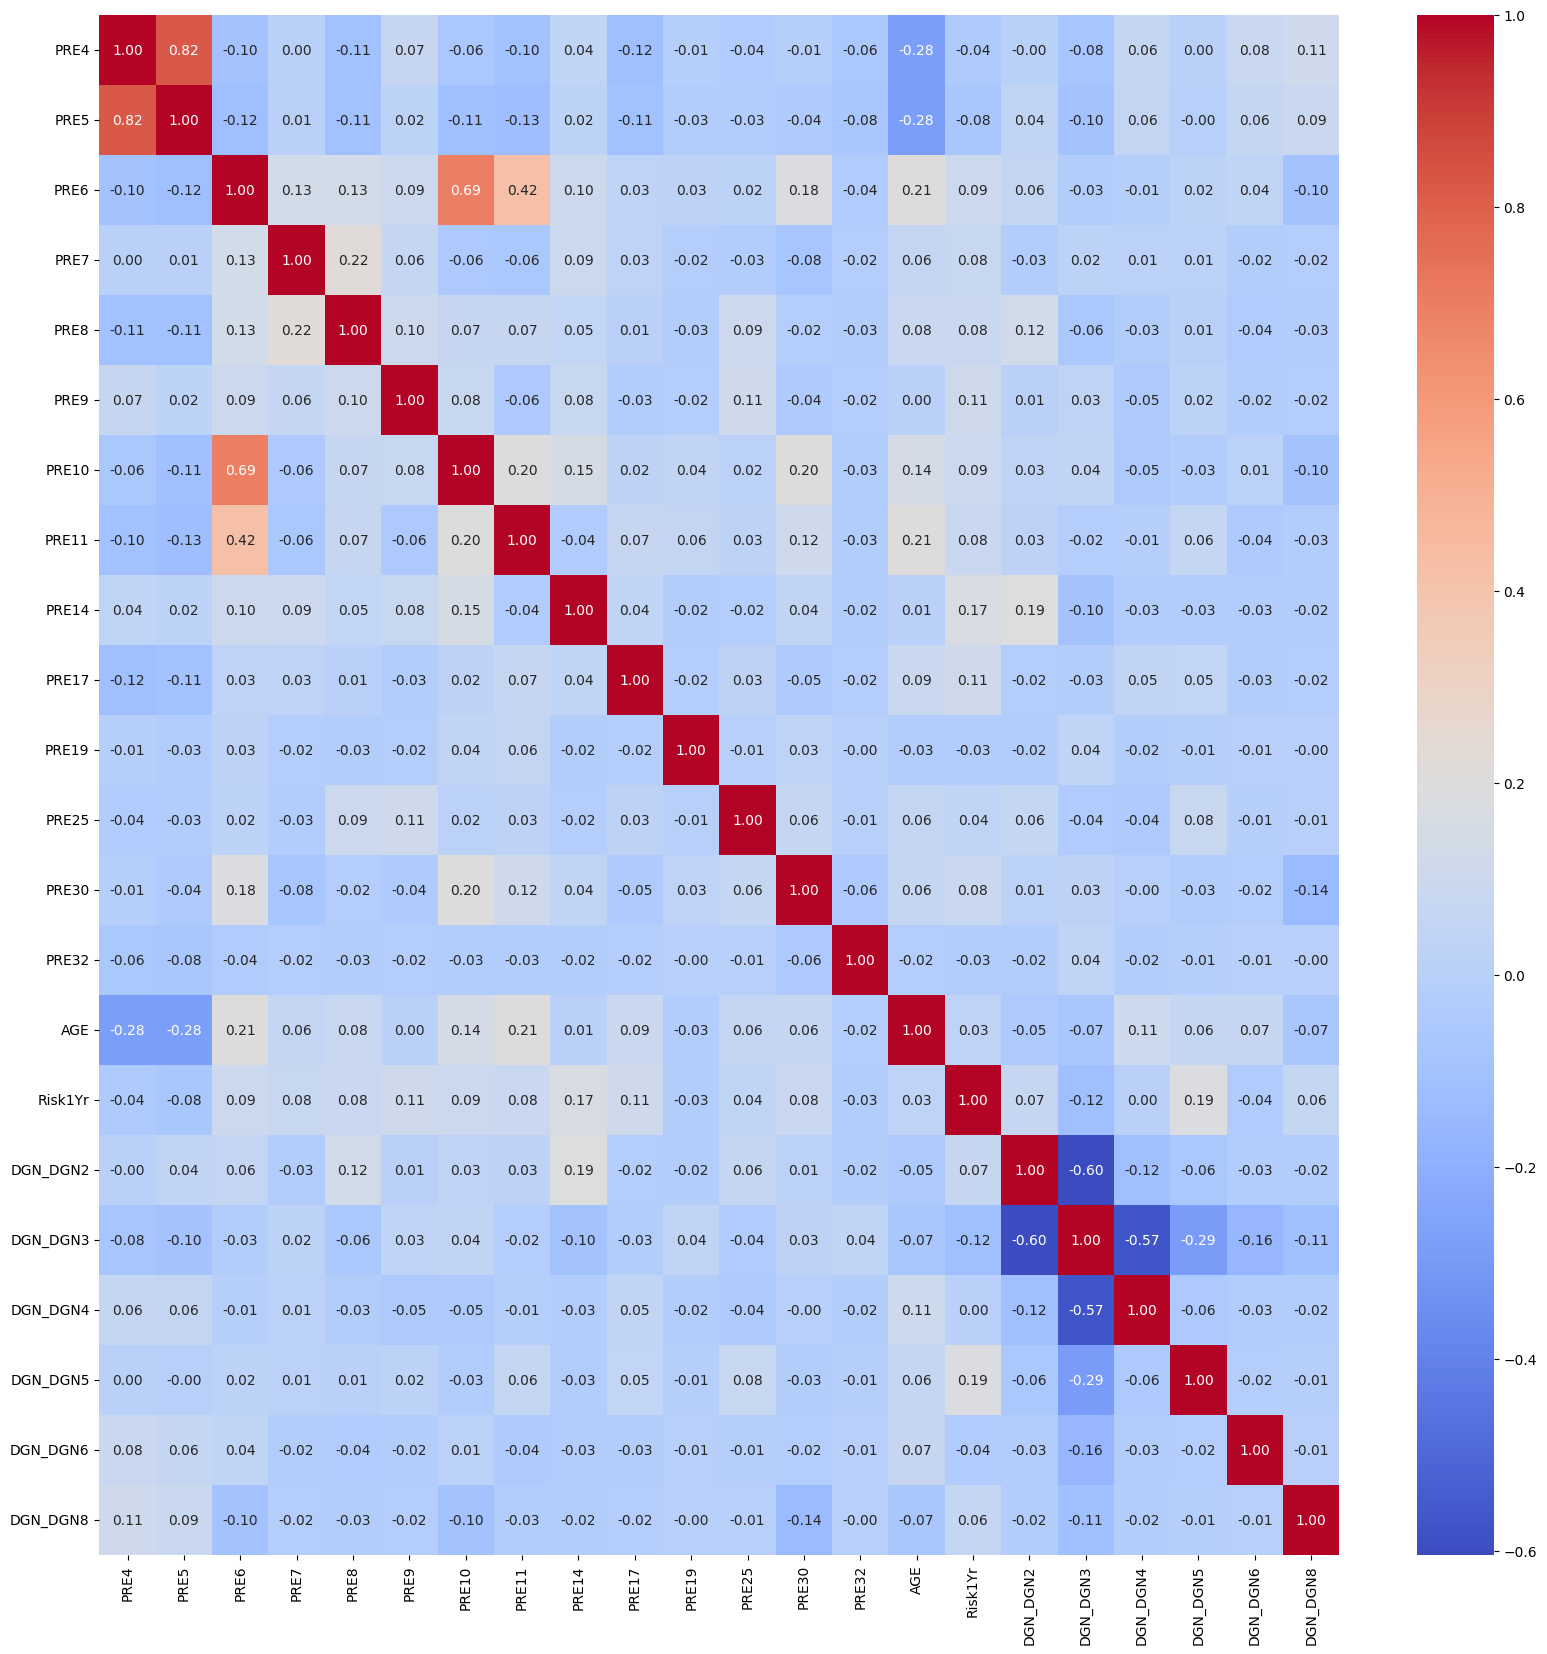

In [91]:
plt.figure(figsize=(20, 20))
sns.heatmap(thoracic_surgery_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [92]:
thoracic_y.value_counts()

Risk1Yr
0.0    387
1.0     69
Name: count, dtype: int64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(thoracic_X, thoracic_y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

# TEST
pred = model.predict(X_test)

# AUROC, F1, PRECISSION, ACCURACY
roc_auc = roc_auc_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f"ROC_AUC: {roc_auc}")
print(f"F1: {f1}")
print(f"PRECISION: {precision}")
print(f"ACCURACY: {accuracy}")

conf_matrix = confusion_matrix(y_test, pred)

print(conf_matrix)

print(f"True Positive: {conf_matrix[1][1]}")
print(f"True Negative: {conf_matrix[0][0]}")
print(f"False Positive: {conf_matrix[0][1]}")
print(f"False Negative: {conf_matrix[1][0]}")

ROC_AUC: 0.5027450980392157
F1: 0.09090909090909091
PRECISION: 0.2
ACCURACY: 0.782608695652174
[[71  4]
 [16  1]]
True Positive: 1
True Negative: 71
False Positive: 4
False Negative: 16


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(thoracic_X, thoracic_y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Training the model on the resampled data
model = XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Testing the model
pred = model.predict(X_test)

# Metrics
roc_auc = roc_auc_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f"ROC_AUC: {roc_auc}")
print(f"F1: {f1}")
print(f"PRECISION: {precision}")
print(f"ACCURACY: {accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, pred)

print(conf_matrix)

print(f"True Positive: {conf_matrix[1][1]}")
print(f"True Negative: {conf_matrix[0][0]}")
print(f"False Positive: {conf_matrix[0][1]}")
print(f"False Negative: {conf_matrix[1][0]}")

### PRIMA

In [22]:
prima_df = pd.read_csv('data/diabetes.csv')

In [23]:
prima_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: >

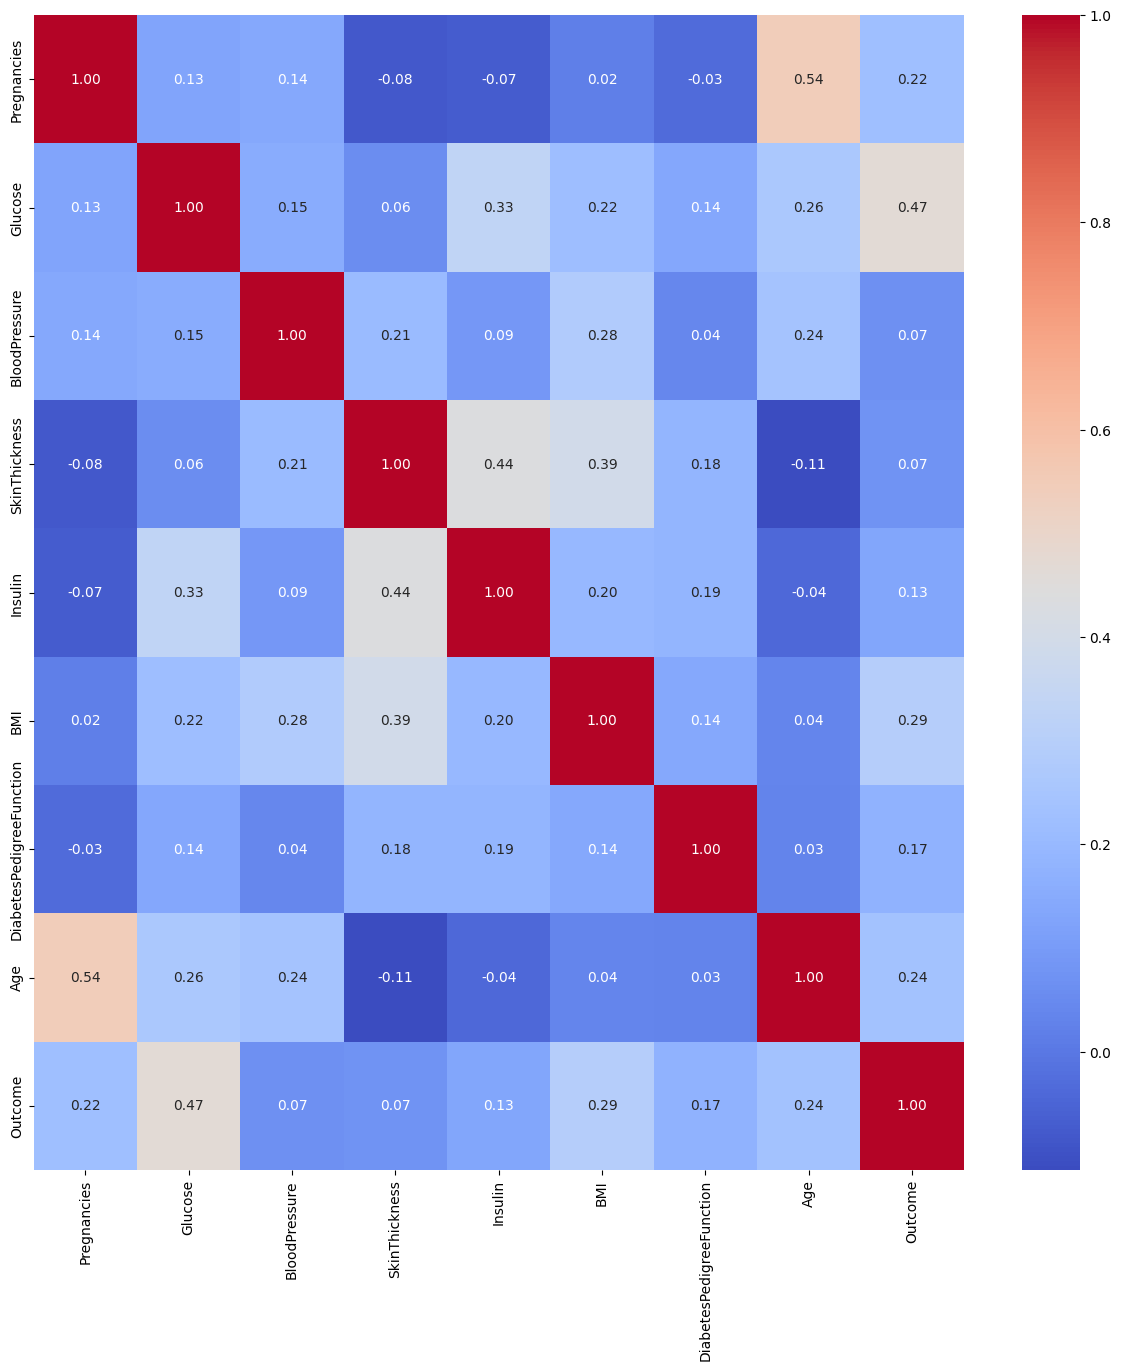

In [24]:
plt.figure(figsize=(15, 15))
sns.heatmap(prima_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [25]:
prima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [27]:
numerical_pima_cols = [col for col in prima_df.columns if prima_df[col].dtype != 'object']
non_numerical_pima_cols = [col for col in prima_df.columns if prima_df[col].dtype == 'object']

print("Numerical columns indeces: " , [prima_df.columns.get_loc(col) for col in numerical_pima_cols])
print("Non-numerical columns indeces: " , [prima_df.columns.get_loc(col) for col in non_numerical_pima_cols])

Numerical columns indeces:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
Non-numerical columns indeces:  []


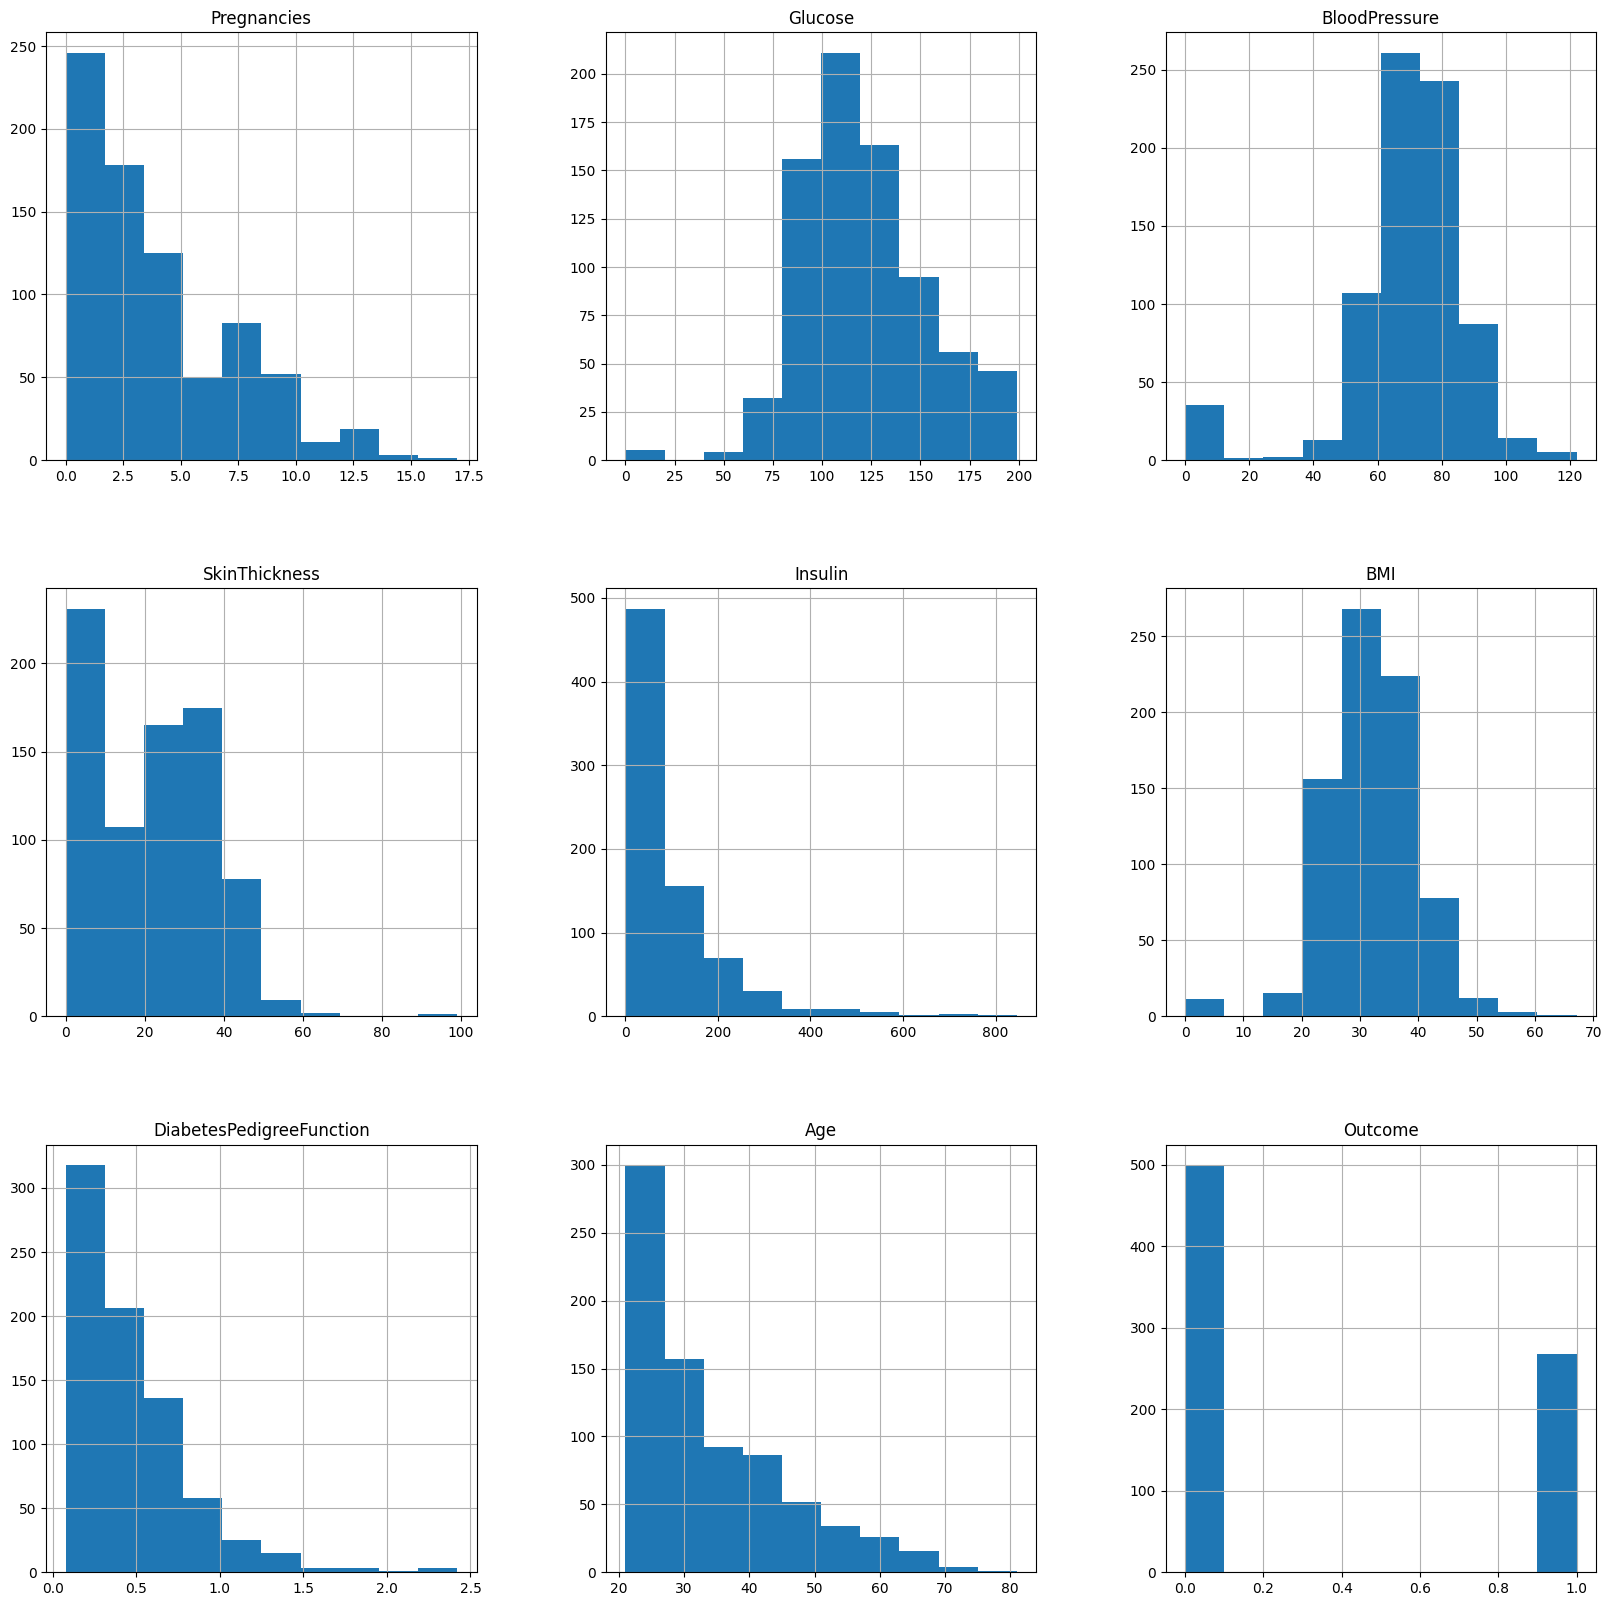

In [26]:
p = prima_df.hist(figsize = (20,20))

In [ ]:
import json

metadata = {
    "name": "pima_diabetes",
    "task_type": "binclass",  # binclass or regression or multiclass
    "header": "infer",
    "column_names": None,
    "num_col_idx": [0, 1, 2, 3, 4, 5, 6, 7, 8],  # list of indices of numerical columns
    "cat_col_idx": [],  # list of indices of categorical columns
    "target_col_idx": [8],  # list of indices of the target columns (for MLE)
    "file_type": "csv",
    "data_path": f"data/pima_diabetes/pima_diabetes.csv",
    "test_path": None,
}
with open("data/Info/pima_diabetes.json", "w") as json_file:
    json.dump(metadata, json_file, indent=4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(prima_X, prima_y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

# TEST
pred = model.predict(X_test)

# AUROC, F1, PRECISSION, ACCURACY
roc_auc = roc_auc_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f"ROC_AUC: {roc_auc}")
print(f"F1: {f1}")
print(f"PRECISION: {precision}")
print(f"ACCURACY: {accuracy}")

conf_matrix = confusion_matrix(y_test, pred)

print(conf_matrix)

### CERVICAL CANCER

In [12]:
  # fetch dataset 
cervical_cancer_risk_factors = fetch_ucirepo(id=383) 
  
# data (as pandas dataframes) 
cervical = cervical_cancer_risk_factors.data.features 

In [14]:
cervical_data = pd.DataFrame(cervical)

cervical_data.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0


In [15]:
cervical_data.isna().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

<Axes: >

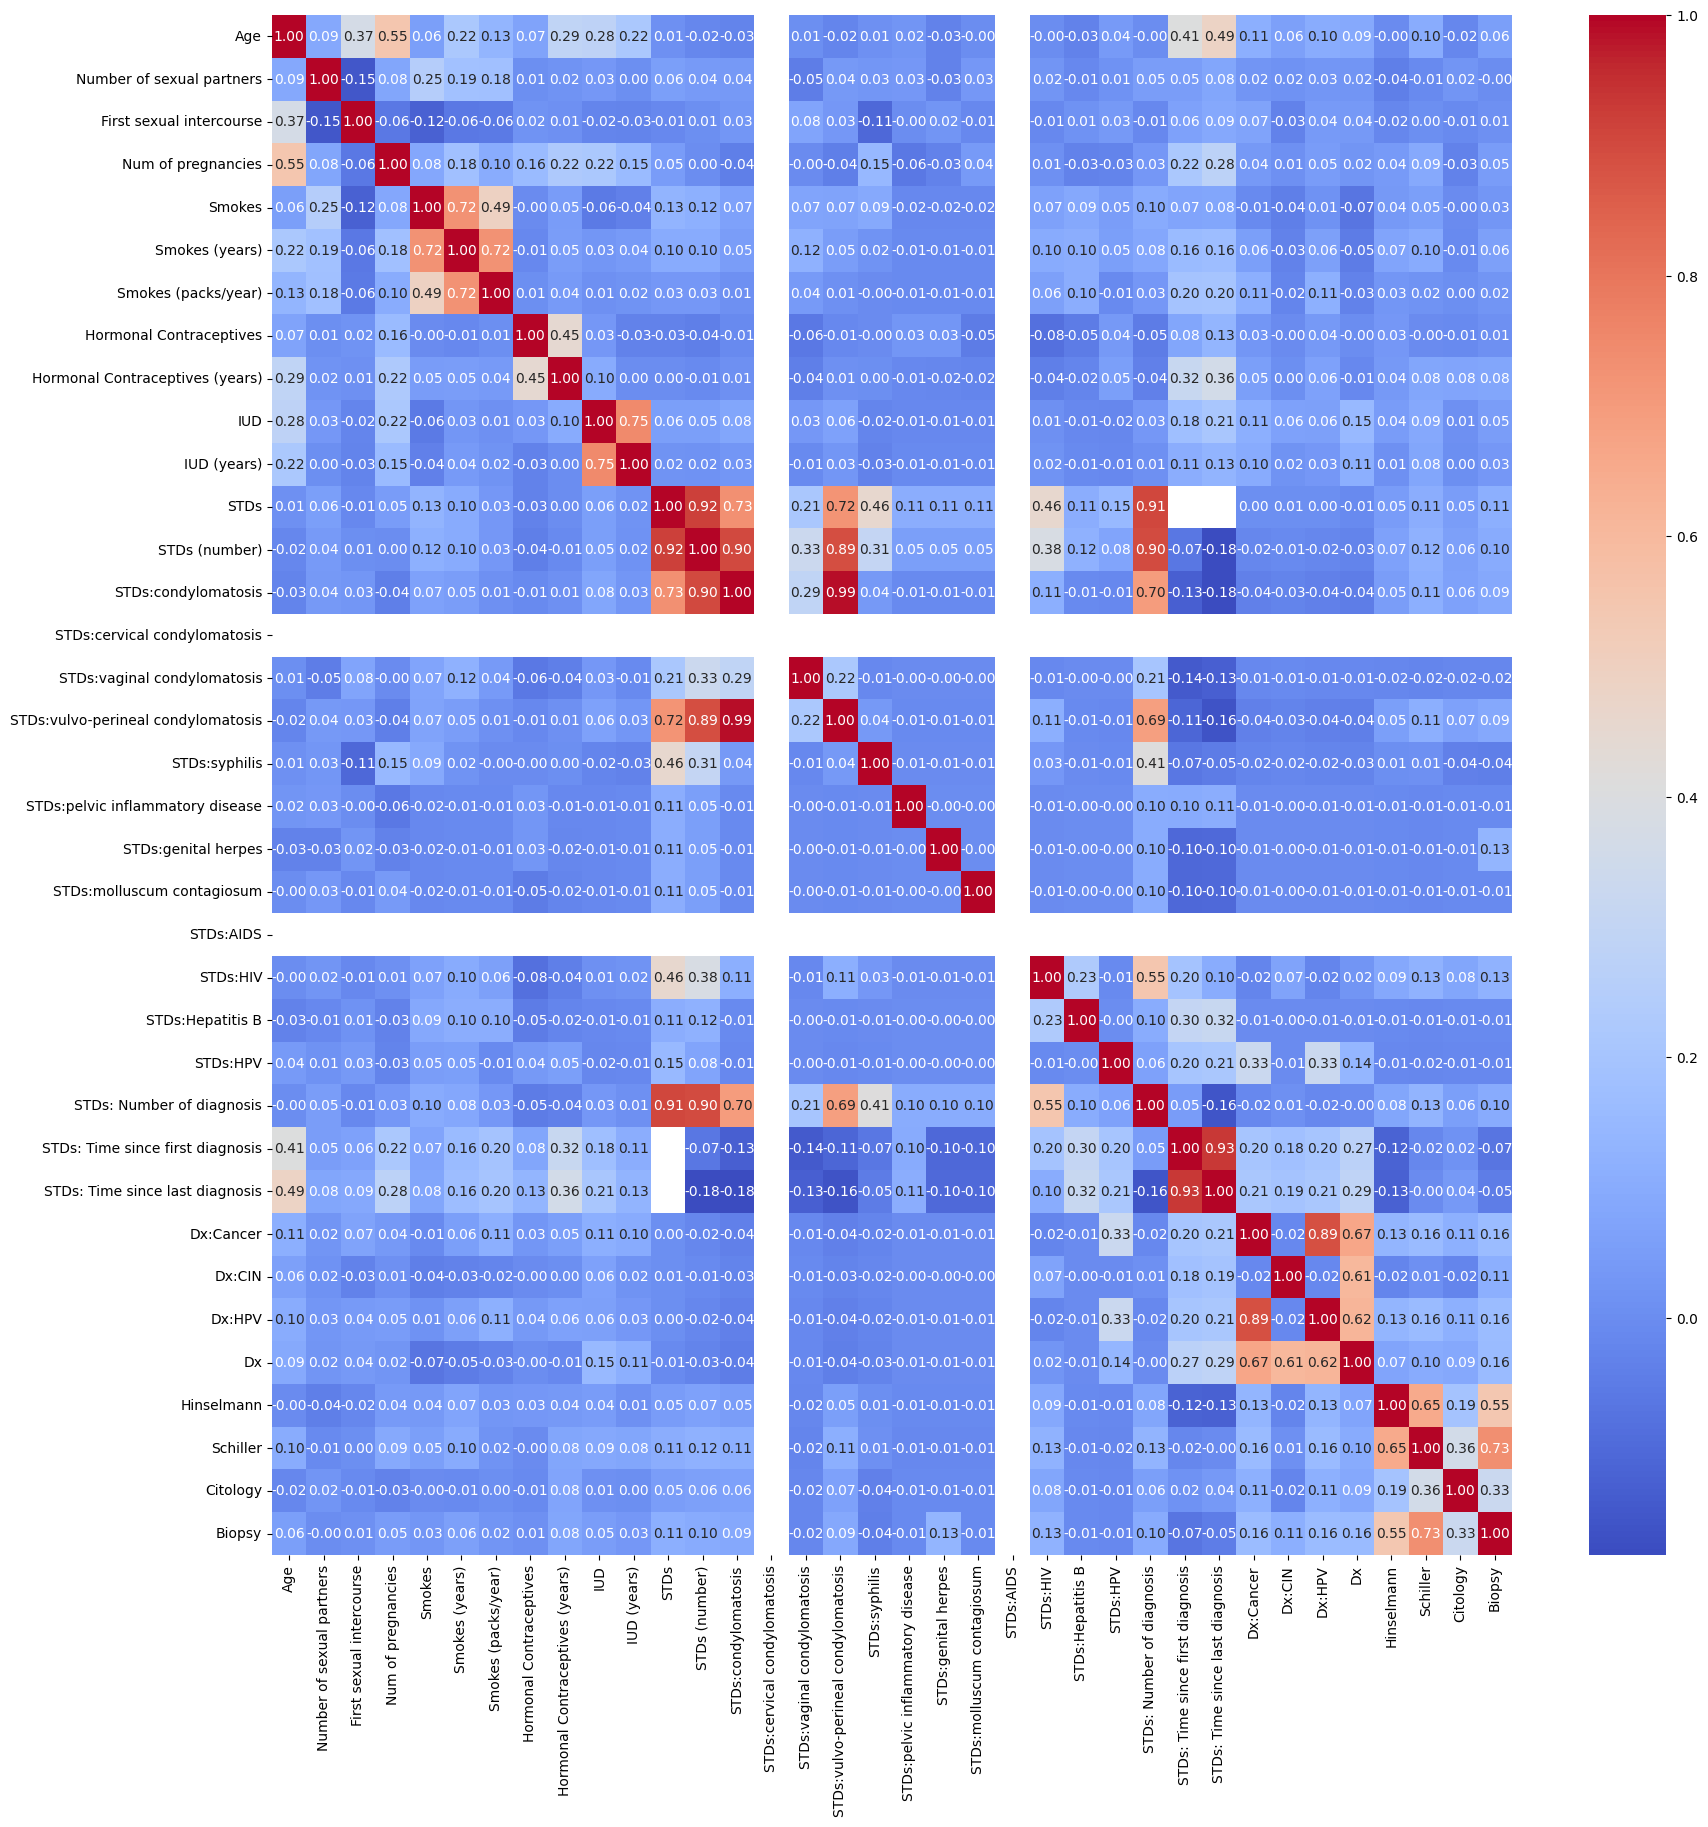

In [16]:
plt.figure(figsize=(20, 20))
sns.heatmap(cervical_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [18]:
cervical_y = cervical["Dx:Cancer"]
cervical_X = cervical.drop(columns=["Dx:Cancer"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cervical_X, cervical_y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

# TEST
pred = model.predict(X_test)


# AUROC, F1, PRECISSION, ACCURACY
roc_auc = roc_auc_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f"ROC_AUC: {roc_auc}")
print(f"F1: {f1}")
print(f"PRECISION: {precision}")
print(f"ACCURACY: {accuracy}")

conf_matrix = confusion_matrix(y_test, pred)

print(f"True Positive: {conf_matrix[1][1]}")
print(f"True Negative: {conf_matrix[0][0]}")
print(f"False Positive: {conf_matrix[0][1]}")
print(f"False Negative: {conf_matrix[1][0]}")

### PARKINSON

In [3]:
# fetch dataset 
parkinsons = fetch_ucirepo(id=174) 
  
# data (as pandas dataframes) 
parkinsons_X = parkinsons.data.features 
parkinsons_y = parkinsons.data.targets

parkinsons_X = parkinsons_X.loc[:, ~parkinsons_X.columns.duplicated()]

In [4]:
parkinsons_X

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00370,0.00554,0.01109,0.04374,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00465,0.00696,0.01394,0.06134,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00544,0.00781,0.01633,0.05233,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00502,0.00698,0.01505,0.05492,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00655,0.00908,0.01966,0.06425,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00263,0.00259,0.00790,0.04087,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00331,0.00292,0.00994,0.02751,0.01604,0.01657,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00624,0.00564,0.01873,0.02308,0.01268,0.01365,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00370,0.00390,0.01109,0.02296,0.01265,0.01321,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(parkinsons_X, parkinsons_y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

# TEST
pred = model.predict(X_test)


# AUROC, F1, PRECISSION, ACCURACY
roc_auc = roc_auc_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f"ROC_AUC: {roc_auc}")
print(f"F1: {f1}")
print(f"PRECISION: {precision}")
print(f"ACCURACY: {accuracy}")

conf_matrix = confusion_matrix(y_test, pred)

print(conf_matrix)

In [ ]:
print(y_train.dtypes)

### RETINOPATHY

In [5]:
# fetch dataset 
diabetic_retinopathy_debrecen = fetch_ucirepo(id=329) 
  
# data (as pandas dataframes) 
retinopathy_X = diabetic_retinopathy_debrecen.data.features 
retinopathy_y = diabetic_retinopathy_debrecen.data.targets 


In [6]:
retinopathy_X = retinopathy_X.loc[:, ~retinopathy_X.columns.duplicated()]

In [7]:
retinopathy_X

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1,1,34,34,34,33,31,24,6.071765,0.937472,0.031145,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0
1147,1,1,49,49,49,49,45,37,63.197145,27.377668,8.067688,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0
1148,1,0,49,48,48,45,43,33,30.461898,13.966980,1.763305,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0
1149,1,1,39,36,29,23,13,7,40.525739,12.604947,4.740919,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1


In [ ]:
retinopathy_y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(retinopathy_X, retinopathy_y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

# TEST

pred = model.predict(X_test)

# AUROC, F1, PRECISSION, ACCURACY

roc_auc = roc_auc_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f"ROC_AUC: {roc_auc}")
print(f"F1: {f1}")
print(f"PRECISION: {precision}")
print(f"ACCURACY: {accuracy}")

conf_matrix = confusion_matrix(y_test, pred)

print(conf_matrix)

### BREAST CANCER

In [8]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
breast_X = breast_cancer_wisconsin_diagnostic.data.features 
breast_Y = breast_cancer_wisconsin_diagnostic.data.targets 

In [9]:
full_data = pd.concat([breast_X, breast_Y], axis=1)
d = full_data[["concave_points1", "perimeter3", "concave_points3", "Diagnosis"]]

In [11]:
full_data

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,M
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,M
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,M
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,M


In [ ]:
# imbalance in breast_Y

breast_Y.replace({'M': 1, 'B': 0}, inplace=True)

print(breast_Y.value_counts())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(breast_X, breast_Y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

# TEST

pred = model.predict(X_test)


# AUROC, F1, PRECISSION, ACCURACY

roc_auc = roc_auc_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(f"ROC_AUC: {roc_auc}")
print(f"F1: {f1}")
print(f"PRECISION: {precision}")
print(f"ACCURACY: {accuracy}")

conf_matrix = confusion_matrix(y_test, pred)

print(conf_matrix)

In [ ]:
from matplotlib import pyplot as plt

# Get feature importance
importance = model.feature_importances_

# If you have feature names
feature_names = X_train.columns  # If X_train is a DataFrame

# Sort feature importances in descending order and create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Optionally, you can plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # To have the most important at the top
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.show()

### OBESITY

In [39]:
# fetch dataset 
obesity = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
obesity_X = obesity.data.features 
obesity_y = obesity.data.targets 

obesity_y = obesity_y.replace({"Insufficient_Weight": 0, "Normal_Weight": 1, "Overweight_Level_I": 2, "Overweight_Level_II": 3, "Obesity_Type_I": 4, "Obesity_Type_II": 5, "Obesity_Type_III": 6})

/tmp/ipykernel_2773049/880871519.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obesity_y = obesity_y.replace({"Insufficient_Weight": 0, "Normal_Weight": 1, "Overweight_Level_I": 2, "Overweight_Level_II": 3, "Obesity_Type_I": 4, "Obesity_Type_II": 5, "Obesity_Type_III": 6})


In [40]:
obesity = pd.concat([obesity_X, obesity_y], axis=1)

In [41]:
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,2
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,3


CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

In [42]:
obesity.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [55]:
from sklearn.preprocessing import LabelEncoder

def clean_and_convert(df):
    # Label Encoding for binary categorical variables
    binary_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    
    le = LabelEncoder()
    for col in binary_columns:
        df[col] = le.fit_transform(df[col])
    
    # One-Hot Encoding for non-binary categorical variables
    one_hot_columns = ['MTRANS']
    df = pd.get_dummies(df, columns=one_hot_columns)
    
    # Lickert Scale
    likert_columns = ['CAEC', 'CALC']
    lickert_dict = {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3}
    
    df[likert_columns] = df[likert_columns].replace(lickert_dict)
    
    # set "NObeyesdad" column the last
    cols = df.columns.tolist()
    cols.remove("NObeyesdad")
    cols.append("NObeyesdad")
    
    df = df[cols]
    
    return df

In [58]:
obesity_processed = clean_and_convert(obesity)
obesity_processed.head()

/tmp/ipykernel_2773049/3234239526.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[likert_columns] = df[likert_columns].replace(lickert_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,False,False,False,True,False,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,False,False,False,True,False,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,False,False,False,True,False,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,False,False,False,False,True,2
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,False,False,False,True,False,3


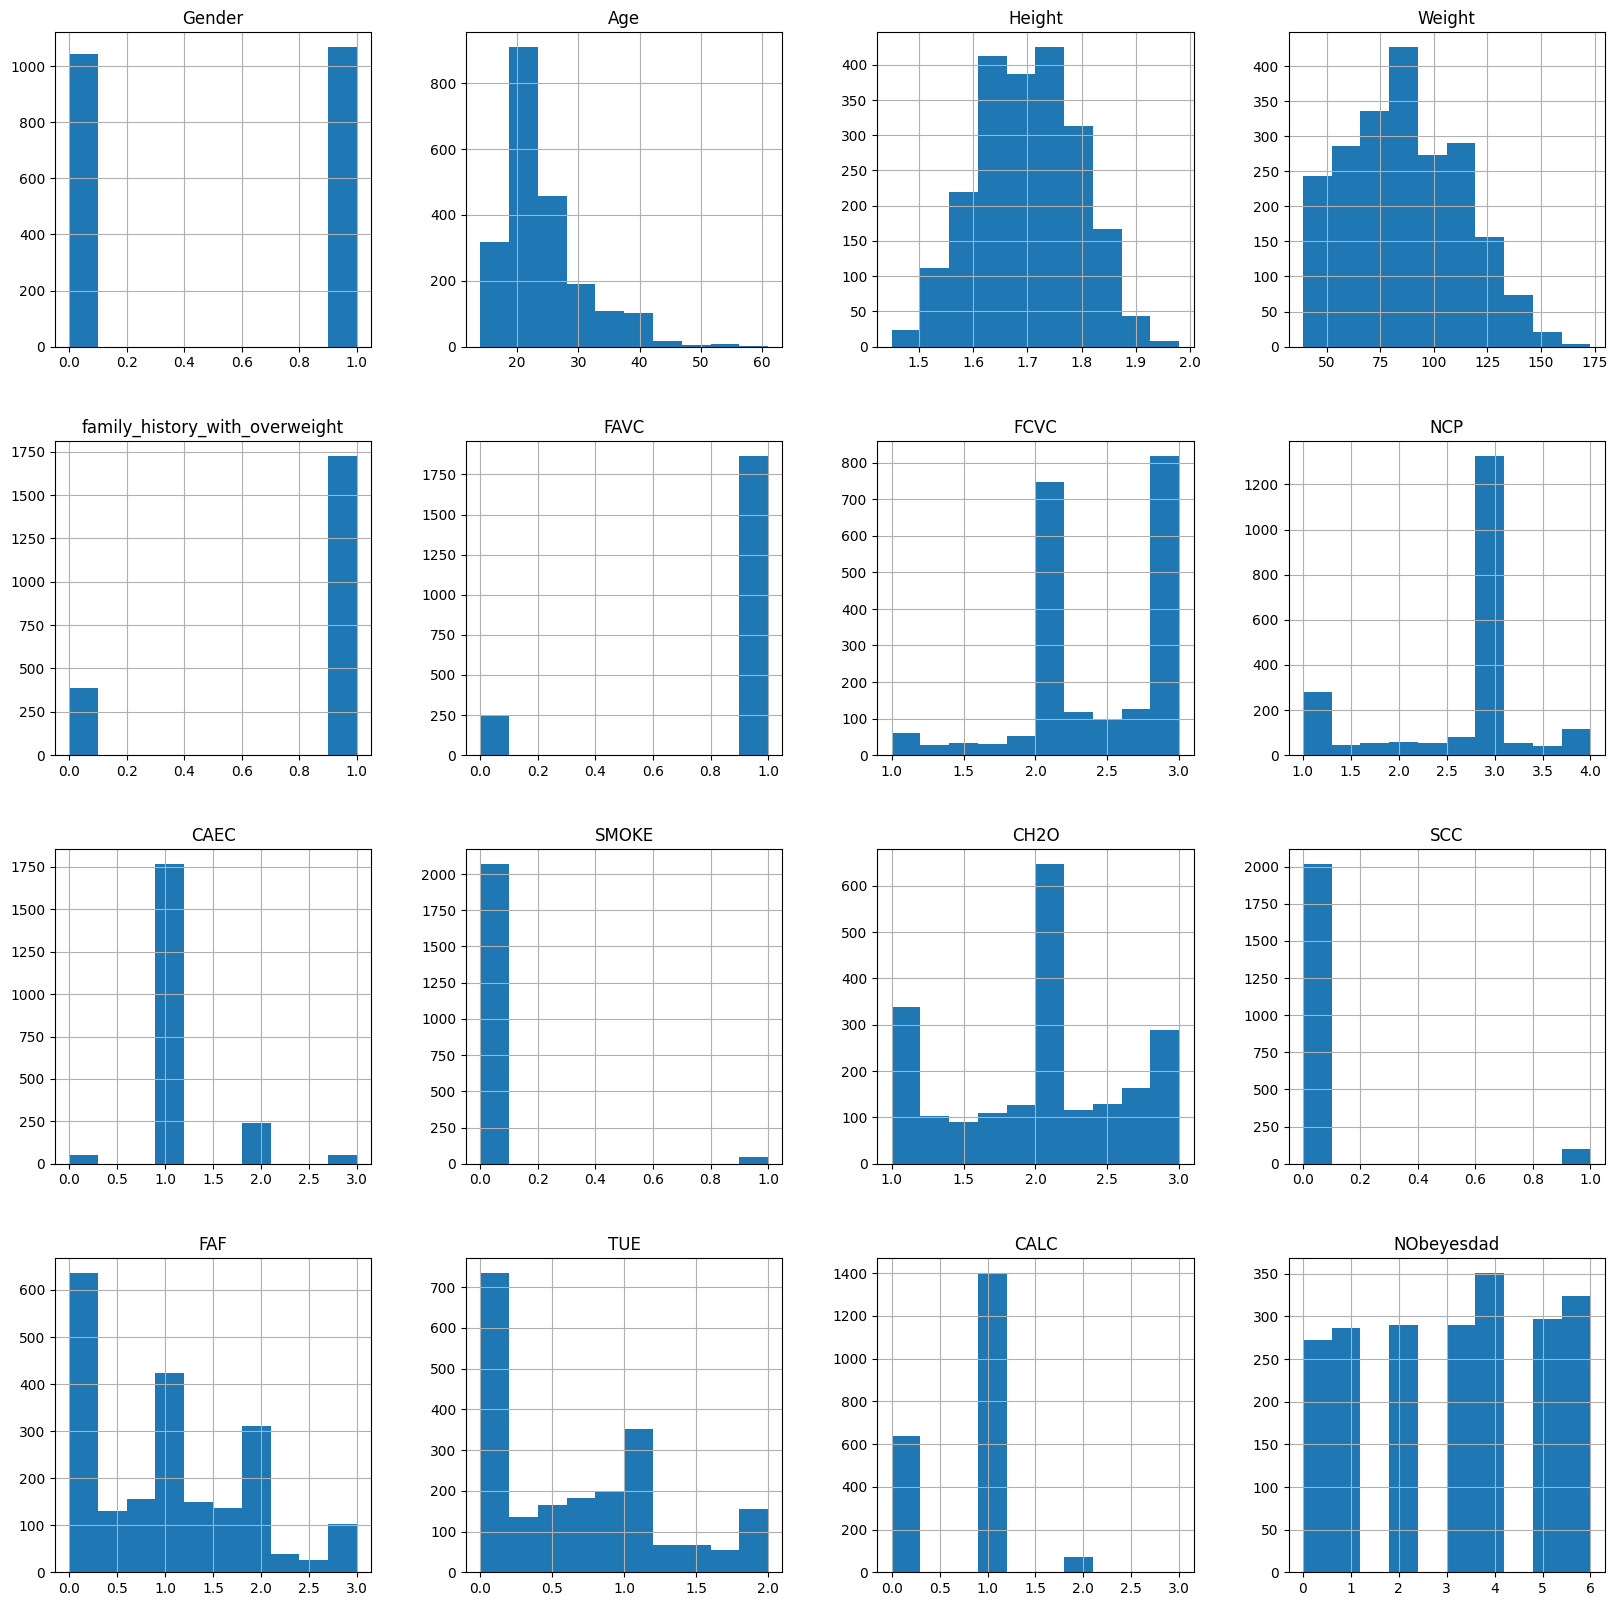

In [59]:
p = obesity_processed.hist(figsize = (20,20))

In [61]:
obesity.NObeyesdad.value_counts()

NObeyesdad
4    351
6    324
5    297
2    290
3    290
1    287
0    272
Name: count, dtype: int64